<a href="https://colab.research.google.com/github/IndraLukasTjahaja/Digital_Credit_Risk/blob/main/Latihan_Credit_Scorecard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Latihan
Google Colab ini adalah template yang dapat digunakan untuk membuat PR/Latihan dari training Credit Scorecard Model dengan Python. Template ini terbagi menjadi dua: yang pertama adalah cara cepat menggunakan library scorecardpy dan yang kedua adalah cara manual.

Peserta training diharapkan dapat membuat scorecard dengan menggunakan kedua metode tersebut.

Setiap peserta memiliki dataset yang berbeda-beda. Hal ini dapat diatur dibagian membaca data

# Membaca Data

## Persiapan data dan impor ke Python

Impor data yang akan digunakan untuk membuat model. Untuk peserta training, gunakan dataset yang telah ditunjuk

In [7]:
# library panda untuk menggunakan data frame
import pandas as pd

# Impor data dari excel xls ke Python
# Pembaca dapat langsung menunjuk kepada file excel yang terletak di website pendamping buku ini
# atau mengunduh terlebih dahulu dan menunjuk ke file excel di lokasi hard drive
# contoh: df = pd.read_excel('C:\User\pembaca\downloads\Credit_Scoring_Dataset.xlsx')

# Untuk Amarda. Tugasnya adalah membuat model dengan dataset berikut:
df = pd.read_excel('https://tjahaja.com/wp-content/uploads/2021/10/german_credit_easy.xlsx')

# Untuk Mila. Tugasnya adalah membuat model dengan dataset berikut:
df = pd.read_excel('https://tjahaja.com/wp-content/uploads/2021/10/OnClass_CreditScoring_data_v2.xlsx')

# Untuk Fadel. Tugasnya adalah membuat model dengan dataset berikut:
df = pd.read_excel('https://tjahaja.com/wp-content/uploads/2021/10/simulation_credit_kaggle_laotse.xlsx')

# Untuk Sidi. Tugasnya adalah membuat model dengan K-S minimum 40 dan ROC lebih dari 0.7
df = pd.read_excel('https://github.com/IndraLukasTjahaja/Digital_Credit_Risk/raw/main/Credit_Scoring_Dataset.xlsx')

# Mohon delete kode read_excel yang bukan tugas kalian

# Struktur dan Tipe Data

In [8]:
df.head(10) # Menampilkan 10 baris teratas dari dataframe df

,ID,gagal_bayar,Lama_Cicilan,Tujuan_Pinjaman,Jumlah_Pinjaman,Pekerjaan,Pendapatan_perbulan,Lama_Bekerja,Status,Kepemilikan_Rumah,Alamat_Rumah,Alamat_Kantor,Usia,Lama_tinggal_ditempat_sekarang,SLIK_Kolektibilitas,SLIK_Cicilan_Bulanan,SLIK_Outstanding_CC,API_CreditScore_Vendor_A,API_CreditScore_Vendor_B,Device_Type,Device_Apps_Installed,Device_Active_Since,Device_Apps_Segmentation,Mobile_Provider,Mobile_Number_Active_Since,Email_Domain_Type
0,ABC0001,0_Bayar,1,elektronik,500000,1_pegawai_tetap,5. >20 juta,5_>7_tahun_kerja,2_menikah,1_milik_sendiri,Daerah_3,Daerah_3,67.0,4_>10_tahun,Kolek 1,859684.752267,0.000000e+00,305,192,Android,6,2_1_ke_3_tahun,Social_Media,Telco_A,1_Kurang_1_bulan,Public_Domain
1,ABC0002,1_Gagal,1,peralatan_rumahtangga,2000000,1_pegawai_tetap,1. < 1 juta,3_1-4_tahun_kerja,1_belum_menikah,1_milik_sendiri,Daerah_2,Daerah_2,22.0,2_1-5_tahun,Kolek 3,743722.804144,1.301412e+06,252,86,IOS,9,3_Lebih_3_tahun,Games,Telco_A,1_Kurang_1_bulan,Public_Domain
2,ABC0003,0_Bayar,3,makanan,1000000,3_wiraswasta,1. < 1 juta,4_4-7_tahun_kerja,2_menikah,1_milik_sendiri,Daerah_2,Daerah_1,49.0,3_5-10_tahun,Kolek 1,265387.462890,0.000000e+00,858,97,Android,36,3_Lebih_3_tahun,Games,Telco_A,2_Kurang_1_tahun,Public_Domain
3,ABC0004,0_Bayar,6,liburan,2000000,1_pegawai_tetap,1. < 1 juta,4_4-7_tahun_kerja,2_menikah,3_bersama_keluarga,Daerah_1,Daerah_1,45.0,4_>10_tahun,Kolek 3,443234.967513,8.094420e+05,108,159,Android,14,3_Lebih_3_tahun,Online_Lending,Telco_E,2_Kurang_1_tahun,Professional_Domain
4,ABC0005,1_Gagal,4,pendidikan,1000000,1_pegawai_tetap,1. < 1 juta,3_1-4_tahun_kerja,2_menikah,3_bersama_keluarga,Daerah_3,Daerah_3,53.0,4_>10_tahun,Kolek 2,102046.058576,7.548064e+05,487,63,Android,10,3_Lebih_3_tahun,Shopping,Telco_D,1_Kurang_1_bulan,Public_Domain
5,ABC0006,0_Bayar,5,makanan,500000,3_wiraswasta,5. >20 juta,3_1-4_tahun_kerja,2_menikah,3_bersama_keluarga,Daerah_1,Daerah_2,35.0,4_>10_tahun,Kolek 3,480608.200003,3.222612e+06,595,200,Android,5,3_Lebih_3_tahun,Social_Media,Telco_A,2_Kurang_1_tahun,Public_Domain
6,ABC0007,0_Bayar,1,liburan,500000,1_pegawai_tetap,3. 5 - 10 juta,5_>7_tahun_kerja,2_menikah,1_milik_sendiri,Daerah_2,Daerah_3,53.0,4_>10_tahun,Kolek 3,133535.433266,4.303138e+05,334,172,Android,37,3_Lebih_3_tahun,Productivity,Telco_C,5_Lebih_5_tahun,Public_Domain
7,ABC0008,0_Bayar,5,buka_bisnis,500000,4_tidak_bekerja,1. < 1 juta,3_1-4_tahun_kerja,2_menikah,2_sewa,Daerah_1,Daerah_1,35.0,2_1-5_tahun,Kolek 3,384367.579947,5.326622e+04,107,186,Android,35,3_Lebih_3_tahun,Productivity,Telco_E,5_Lebih_5_tahun,Public_Domain
8,ABC0009,0_Bayar,1,peralatan_rumahtangga,500000,3_wiraswasta,4. 10 - 20 juta,4_4-7_tahun_kerja,3_bercerai,1_milik_sendiri,Daerah_2,Daerah_1,61.0,4_>10_tahun,Kolek 3,527874.467181,1.954899e+06,45,235,IOS,17,2_1_ke_3_tahun,Social_Media,Telco_A,3_1_ke_2_tahun,Public_Domain
9,ABC0010,1_Gagal,3,liburan,500000,4_tidak_bekerja,1. < 1 juta,1_tidak_bekerja,3_bercerai,1_milik_sendiri,Daerah_2,Daerah_2,28.0,2_1-5_tahun,Kolek 1,226586.344920,0.000000e+00,254,285,Android,17,2_1_ke_3_tahun,Social_Media,Telco_C,1_Kurang_1_bulan,Public_Domain


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              1000 non-null   object 
 1   gagal_bayar                     1000 non-null   object 
 2   Lama_Cicilan                    1000 non-null   int64  
 3   Tujuan_Pinjaman                 1000 non-null   object 
 4   Jumlah_Pinjaman                 1000 non-null   int64  
 5   Pekerjaan                       988 non-null    object 
 6   Pendapatan_perbulan             990 non-null    object 
 7   Lama_Bekerja                    973 non-null    object 
 8   Status                          996 non-null    object 
 9   Kepemilikan_Rumah               997 non-null    object 
 10  Alamat_Rumah                    1000 non-null   object 
 11  Alamat_Kantor                   1000 non-null   object 
 12  Usia                            999

# Data Preparation

## Missing data treatment

Asumsi jika ada baris data yang hilang, maka akan kita buang saja

In [12]:
# Menggunakan fungsi dropna() untuk menghapus semua baris yang memiliki data kosong
df_clean = df.dropna()
df_clean.reset_index(drop=True)

,ID,gagal_bayar,Lama_Cicilan,Tujuan_Pinjaman,Jumlah_Pinjaman,Pekerjaan,Pendapatan_perbulan,Lama_Bekerja,Status,Kepemilikan_Rumah,Alamat_Rumah,Alamat_Kantor,Usia,Lama_tinggal_ditempat_sekarang,SLIK_Kolektibilitas,SLIK_Cicilan_Bulanan,SLIK_Outstanding_CC,API_CreditScore_Vendor_A,API_CreditScore_Vendor_B,Device_Type,Device_Apps_Installed,Device_Active_Since,Device_Apps_Segmentation,Mobile_Provider,Mobile_Number_Active_Since,Email_Domain_Type
0,ABC0001,0_Bayar,1,elektronik,500000,1_pegawai_tetap,5. >20 juta,5_>7_tahun_kerja,2_menikah,1_milik_sendiri,Daerah_3,Daerah_3,67.0,4_>10_tahun,Kolek 1,859684.752267,0.000000e+00,305,192,Android,6,2_1_ke_3_tahun,Social_Media,Telco_A,1_Kurang_1_bulan,Public_Domain
1,ABC0002,1_Gagal,1,peralatan_rumahtangga,2000000,1_pegawai_tetap,1. < 1 juta,3_1-4_tahun_kerja,1_belum_menikah,1_milik_sendiri,Daerah_2,Daerah_2,22.0,2_1-5_tahun,Kolek 3,743722.804144,1.301412e+06,252,86,IOS,9,3_Lebih_3_tahun,Games,Telco_A,1_Kurang_1_bulan,Public_Domain
2,ABC0003,0_Bayar,3,makanan,1000000,3_wiraswasta,1. < 1 juta,4_4-7_tahun_kerja,2_menikah,1_milik_sendiri,Daerah_2,Daerah_1,49.0,3_5-10_tahun,Kolek 1,265387.462890,0.000000e+00,858,97,Android,36,3_Lebih_3_tahun,Games,Telco_A,2_Kurang_1_tahun,Public_Domain
3,ABC0004,0_Bayar,6,liburan,2000000,1_pegawai_tetap,1. < 1 juta,4_4-7_tahun_kerja,2_menikah,3_bersama_keluarga,Daerah_1,Daerah_1,45.0,4_>10_tahun,Kolek 3,443234.967513,8.094420e+05,108,159,Android,14,3_Lebih_3_tahun,Online_Lending,Telco_E,2_Kurang_1_tahun,Professional_Domain
4,ABC0005,1_Gagal,4,pendidikan,1000000,1_pegawai_tetap,1. < 1 juta,3_1-4_tahun_kerja,2_menikah,3_bersama_keluarga,Daerah_3,Daerah_3,53.0,4_>10_tahun,Kolek 2,102046.058576,7.548064e+05,487,63,Android,10,3_Lebih_3_tahun,Shopping,Telco_D,1_Kurang_1_bulan,Public_Domain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,ABC0996,0_Bayar,2,makanan,500000,3_wiraswasta,1. < 1 juta,4_4-7_tahun_kerja,1_belum_menikah,1_milik_sendiri,Daerah_2,Daerah_1,31.0,4_>10_tahun,Kolek 3,529181.416024,4.279152e+06,347,304,Android,37,2_1_ke_3_tahun,Social_Media,Telco_A,3_1_ke_2_tahun,Public_Domain
944,ABC0997,0_Bayar,5,buka_bisnis,1000000,4_tidak_bekerja,1. < 1 juta,3_1-4_tahun_kerja,3_bercerai,1_milik_sendiri,Daerah_2,Daerah_3,40.0,4_>10_tahun,Kolek 3,540906.362253,2.200963e+06,650,306,Android,28,2_1_ke_3_tahun,Shopping,Telco_A,3_1_ke_2_tahun,Public_Domain
945,ABC0998,0_Bayar,1,elektronik,500000,1_pegawai_tetap,1. < 1 juta,5_>7_tahun_kerja,2_menikah,1_milik_sendiri,Daerah_3,Daerah_1,38.0,4_>10_tahun,Kolek 3,176687.269451,4.872431e+05,374,69,Android,35,3_Lebih_3_tahun,Shopping,Telco_B,2_Kurang_1_tahun,Public_Domain
946,ABC0999,1_Gagal,6,elektronik,500000,1_pegawai_tetap,1. < 1 juta,3_1-4_tahun_kerja,2_menikah,3_bersama_keluarga,Daerah_2,Daerah_1,23.0,4_>10_tahun,Kolek 3,754376.617614,5.490140e+06,328,63,Android,13,3_Lebih_3_tahun,Social_Media,Telco_E,4_2_ke_5_tahun,Public_Domain


# Data Exploration

Pada bagian ini silahkan melakukan eksplorasi data seperti yang kita lakukan ketika training

## Pembuatan Variabel baru

Jangan lupa untuk membuat variabel baru dan variabel target dalam bentuk angka (jika belum ada)

In [13]:
import numpy as np

# Untuk dapat melakukan analisa statistik, harus mengubah variabel gagal_bayar dari string menjadi angka (integer)
# Mengubah target variabel gagal_bayar menjadi angka 0 dan 1
conditions = [
             df_clean['gagal_bayar'] == '1_Gagal', 
             df_clean['gagal_bayar'] == '0_Bayar'
             ]

choices     = [
             1,
             0
             ]
df_clean['default'] = np.select(conditions,choices, default = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Data Modeling cara cepat dengan Scorecardpy

## Instalasi library scorecardpy terlebih dahulu

In [11]:
# install scorecardpy
!pip install -q scorecardpy
#!pip install git+git://github.com/shichenxie/scorecardpy.git

## Memilih variabel untuk model

In [14]:
df_model = df_clean[['default','SLIK_Kolektibilitas','Tujuan_Pinjaman']]

## Persiapan Modeling, train dan test dataset, pembuatan binning dan EDA

[INFO] creating woe binning ...
[INFO] creating woe binning ...


{'SLIK_Kolektibilitas': <Figure size 432x288 with 2 Axes>,
 'Tujuan_Pinjaman': <Figure size 432x288 with 2 Axes>}

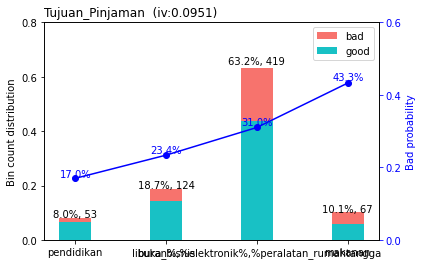

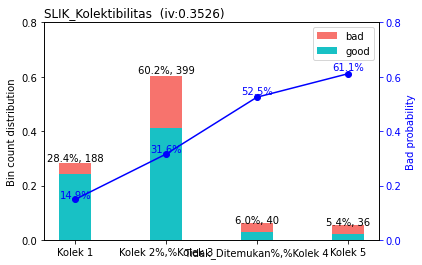

In [17]:
y = df_model.loc[:,'default']
X = df_model.loc[:,df_model.columns != 'default']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Dalam bentuk dataframe lengkap
df_train = pd.concat([X_train, y_train], axis = 1)
df_test = pd.concat([X_test, y_test], axis = 1)

# Menghapus indeks dari data yang telah dibuang
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Credit Scoring using logistic regression with library scorecardpy
import scorecardpy as scpy

# Melakukan WOE binning
bins = scpy.woebin(df_train, y = 'default')

# Melakukan WOE binning dengan adjustment
breaks_adj = {
}
bins_adj = scpy.woebin(df_train, y="default", breaks_list=breaks_adj)

scpy.woebin_plot(bins_adj)

## Pembuatan WOE secara otomatis

In [18]:
train = df_train
test = df_test

# converting train and test into woe values
train_woe = scpy.woebin_ply(train, bins_adj)
test_woe = scpy.woebin_ply(test, bins_adj)

y_train = train_woe.loc[:,'default']
X_train = train_woe.loc[:,train_woe.columns != 'default']
y_test = test_woe.loc[:,'default']
X_test = test_woe.loc[:,train_woe.columns != 'default']

[INFO] converting into woe values ...
[INFO] converting into woe values ...


## Model dengan logistic regression dan hasil Scorecard

In [19]:
# Membuat scorecard dengan menggunakan algoritma logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

print(lr.coef_)

[[1.06131874 1.01554216]]


## Hasil Scorecard

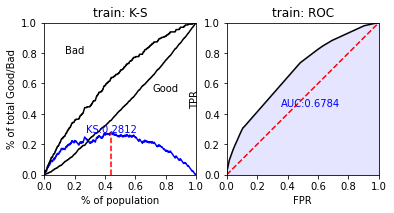

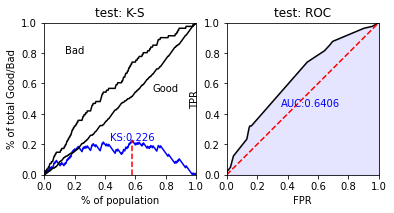

{'basepoints':      variable  bin  points
0  basepoints  NaN     446, 'Tujuan_Pinjaman':           variable                                           bin  points
0  Tujuan_Pinjaman                                    pendidikan    56.0
1  Tujuan_Pinjaman                                   buka_bisnis    25.0
2  Tujuan_Pinjaman  liburan%,%elektronik%,%peralatan_rumahtangga    -5.0
3  Tujuan_Pinjaman                                       makanan   -45.0, 'SLIK_Kolektibilitas':               variable                        bin  points
4  SLIK_Kolektibilitas                    Kolek 1    65.0
5  SLIK_Kolektibilitas          Kolek 2%,%Kolek 3    -6.0
6  SLIK_Kolektibilitas  Tidak_Ditemukan%,%Kolek 4   -70.0
7  SLIK_Kolektibilitas                    Kolek 5   -96.0}


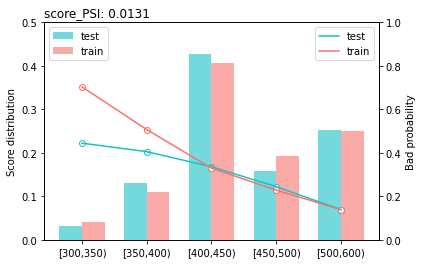

{'pic': {'score': <Figure size 432x288 with 2 Axes>},
 'psi':   variable       PSI
 0    score  0.013138}

In [21]:
# predicted probability
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

# performance ks & roc ------
train_perf = scpy.perf_eva(y_train, train_pred, title = "train")
test_perf = scpy.perf_eva(y_test, test_pred, title = "test")

# score ------
card = scpy.scorecard(bins_adj, lr, X_train.columns, points0=600, odds0=1/20, pdo=50, basepoints_eq0=False)
print(card)
# credit score
train_score = scpy.scorecard_ply(train, card, print_step=0)
test_score = scpy.scorecard_ply(test, card, print_step=0)

# psi
scpy.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)

